# Importing Libraries

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from xgboost.sklearn import XGBRegressor 
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import BaggingRegressor
import math
sns.set()

## Reading Data

In [2]:
sample_sub = pd.read_csv(r"D:\Data Science Course\Projects\Analytics vidya\Big Mart Sales Prediction\sample_submission_8RXa3c6.csv")
train = pd.read_csv(r"D:\Data Science Course\Projects\Analytics vidya\Big Mart Sales Prediction\train_v9rqX0R.csv")
test = pd.read_csv(r"D:\Data Science Course\Projects\Analytics vidya\Big Mart Sales Prediction\test_AbJTz2l.csv")

In [3]:
print('Shape of train data: {}'.format(train.shape))
print('Shape of test data: {}'.format(test.shape))

Shape of train data: (8523, 12)
Shape of test data: (5681, 11)


# Feature Dictionary
Item_Identifier : Unique product ID (Informative)

Item_Weight : Weight of product (Continuous)

Item_Fat_Content : Whether the product is low fat or not (Categorical)

Item_Visibility : The % of total display area of all products in a store allocated to the particular product (Continuous)

Item_Type : The category to which the product belongs (Categorical)

Item_MRP : Maximum Retail Price (list price) of the product (Continuous)

Outlet_Identifier : Unique store ID (Informative)

Outlet_Establishment_Year : The year in which store was established (Informative)

Outlet_Size : The size of the store in terms of ground area covered (Categorical)

Outlet_Location_Type : The type of city in which the store is located (Categorical)

Outlet_Type : Whether the outlet is just a grocery store or some sort of supermarket (Categorical)

Item_Outlet_Sales : Sales of the product in the particular store. This is the outcome variable to be predicted. (Target)`m

---
### Setting train flag and Merging Datasets

In [4]:
train['is_train'] = 1
test['is_train'] = 0
test['Item_Outlet_Sales'] = None

In [5]:
data = pd.concat((train,test))
data.shape

(14204, 13)

In [6]:
data.describe().T

count         mean        std       min  \
Item_Weight                11765.0    12.792854   4.652502     4.555   
Item_Visibility            14204.0     0.065953   0.051459     0.000   
Item_MRP                   14204.0   141.004977  62.086938    31.290   
Outlet_Establishment_Year  14204.0  1997.830681   8.371664  1985.000   
is_train                   14204.0     0.600042   0.489907     0.000   

                                   25%          50%          75%          max  
Item_Weight                   8.710000    12.600000    16.750000    21.350000  
Item_Visibility               0.027036     0.054021     0.094037     0.328391  
Item_MRP                     94.012000   142.247000   185.855600   266.888400  
Outlet_Establishment_Year  1987.000000  1999.000000  2004.000000  2009.000000  
is_train                      0.000000     1.000000     1.000000     1.000000

---
# Data Cleaning

In [7]:
data['Item_Fat_Content'].value_counts()

Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

In [8]:
data['Item_Fat_Content'].replace( {'low fat':'Low Fat', 'LF':'Low Fat', 'reg':'Regular'}, inplace=True)

---
# Missing Value Analysis

In [9]:
data.isna().sum()/data.shape[0]*100

Item_Identifier               0.000000
Item_Weight                  17.171219
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.273726
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
Item_Outlet_Sales            39.995776
is_train                      0.000000
dtype: float64

### Imputing 'Item_Weight'

In [10]:
# Finding Relation Between "Item_Identifier" and 'Item_Weight'

data[ data['Item_Identifier'] == 'FDA15']

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility Item_Type  \
0              FDA15          9.3          Low Fat         0.016047     Dairy   
831            FDA15          9.3          Low Fat         0.016055     Dairy   
2599           FDA15          9.3          Low Fat         0.016019     Dairy   
2643           FDA15          9.3          Low Fat         0.016088     Dairy   
4874           FDA15          9.3          Low Fat         0.026818     Dairy   
5413           FDA15          9.3          Low Fat         0.016009     Dairy   
6696           FDA15          NaN          Low Fat         0.015945     Dairy   
7543           FDA15          9.3          Low Fat         0.016113     Dairy   
1115           FDA15          9.3          Low Fat         0.016022     Dairy   

      Item_MRP Outlet_Identifier  Outlet_Establishment_Year Outlet_Size  \
0     249.8092            OUT049                       1999      Medium   
831   250.2092            OUT045                       2002         NaN   
2599  248.5092            OUT035                       2004       Small   
2643  249.6092            OUT018                       2009      Medium   
4874  248.9092            OUT010                       1998         NaN   
5413  250.6092            OUT013                       1987        High   
6696  249.5092            OUT027                       1985      Medium   
7543  248.8092            OUT017                       2007         NaN   
1115  249.9092            OUT046                       1997       Small   

     Outlet_Location_Type        Outlet_Type Item_Outlet_Sales  is_train  
0                  Tier 1  Supermarket Type1           3735.14         1  
831                Tier 2  Supermarket Type1           5976.22         1  
2599               Tier 2  Supermarket Type1           6474.24         1  
2643               Tier 3  Supermarket Type2           5976.22         1  
4874               Tier 3      Grocery Store           498.018         1  
5413               Tier 3  Supermarket Type1           6474.24         1  
6696               Tier 3  Supermarket Type3           6474.24         1  
7543               Tier 2  Supermarket Type1           5976.22         1  
1115               Tier 1  Supermarket Type1              None         0

In [11]:
# Creating Dictionary : { 'Item_Identifier' : 'Iten_Weight'(mode)}

weight_dict = data.groupby('Item_Identifier')['Item_Weight'].agg(pd.Series.mode).to_dict()

##### Imputing "Item_Weight" by mode 'Item_Weight' value  for particular "Item_Identifier"

In [12]:
data.loc[ data['Item_Weight'].isna(), 'Item_Weight'] = data[ data['Item_Weight'].isna()]['Item_Identifier'].apply(lambda x: weight_dict[x])

---
### Imputing "Outlet_Size"

In [13]:
data.head()

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0           FDA15         9.30          Low Fat         0.016047   
1           DRC01         5.92          Regular         0.019278   
2           FDN15        17.50          Low Fat         0.016760   
3           FDX07        19.20          Regular         0.000000   
4           NCD19         8.93          Low Fat         0.000000   

               Item_Type  Item_MRP Outlet_Identifier  \
0                  Dairy  249.8092            OUT049   
1            Soft Drinks   48.2692            OUT018   
2                   Meat  141.6180            OUT049   
3  Fruits and Vegetables  182.0950            OUT010   
4              Household   53.8614            OUT013   

   Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0                       1999      Medium               Tier 1   
1                       2009      Medium               Tier 3   
2                       1999      Medium               Tier 1   
3                       1998         NaN               Tier 3   
4                       1987        High               Tier 3   

         Outlet_Type Item_Outlet_Sales  is_train  
0  Supermarket Type1           3735.14         1  
1  Supermarket Type2           443.423         1  
2  Supermarket Type1           2097.27         1  
3      Grocery Store            732.38         1  
4  Supermarket Type1           994.705         1

In [14]:
data['Outlet_Size'].value_counts()

Medium    4655
Small     3980
High      1553
Name: Outlet_Size, dtype: int64

In [15]:
data['Outlet_Identifier'].unique()

array(['OUT049', 'OUT018', 'OUT010', 'OUT013', 'OUT027', 'OUT045',
       'OUT017', 'OUT046', 'OUT035', 'OUT019'], dtype=object)

In [16]:
data[ data['Outlet_Size'].isna()].groupby('Outlet_Identifier')['Outlet_Establishment_Year'].value_counts()

Outlet_Identifier  Outlet_Establishment_Year
OUT010             1998                          925
OUT017             2007                         1543
OUT045             2002                         1548
Name: Outlet_Establishment_Year, dtype: int64

In [17]:
data['Outlet_Location_Type'].unique()

array(['Tier 1', 'Tier 3', 'Tier 2'], dtype=object)

In [18]:
data['Outlet_Type'].unique()

array(['Supermarket Type1', 'Supermarket Type2', 'Grocery Store',
       'Supermarket Type3'], dtype=object)

In [19]:
data[ data['Outlet_Type'] == 'Grocery Store']['Outlet_Size'].value_counts()

Small    880
Name: Outlet_Size, dtype: int64

In [20]:
data[ data['Outlet_Size'].isna()]['Outlet_Type'].value_counts()

Supermarket Type1    3091
Grocery Store         925
Name: Outlet_Type, dtype: int64

### Insight: 

All the Grocery Stores have `Small` 'Outlet_Size'.

So we will impute missing values of 'Outlet_Size' as `Small` for rows which have 'Outlet_Type' as `Grocery Store`

In [21]:
data.loc[ (data['Outlet_Size'].isna()) & (data['Outlet_Type'] == 'Grocery Store'), 'Outlet_Size'] = 'Small'

In [22]:
data[ data['Outlet_Size'].isna()]['Outlet_Type'].value_counts()

Supermarket Type1    3091
Name: Outlet_Type, dtype: int64

In [23]:
data[ data['Outlet_Type'] == 'Supermarket Type1']#['Outlet_Size'].value_counts()

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0              FDA15         9.30          Low Fat         0.016047   
2              FDN15        17.50          Low Fat         0.016760   
4              NCD19         8.93          Low Fat         0.000000   
6              FDO10        13.65          Regular         0.012741   
8              FDH17        16.20          Regular         0.016687   
...              ...          ...              ...              ...   
5675           FDW46        13.00          Regular         0.070411   
5676           FDB58        10.50          Regular         0.013496   
5678           NCO17        10.00          Low Fat         0.073529   
5679           FDJ26        15.30          Regular         0.000000   
5680           FDU37         9.50          Regular         0.104720   

               Item_Type  Item_MRP Outlet_Identifier  \
0                  Dairy  249.8092            OUT049   
2                   Meat  141.6180            OUT049   
4              Household   53.8614            OUT013   
6            Snack Foods   57.6588            OUT013   
8           Frozen Foods   96.9726            OUT045   
...                  ...       ...               ...   
5675         Snack Foods   63.4484            OUT049   
5676         Snack Foods  141.3154            OUT046   
5678  Health and Hygiene  118.7440            OUT045   
5679              Canned  214.6218            OUT017   
5680              Canned   79.7960            OUT045   

      Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0                          1999      Medium               Tier 1   
2                          1999      Medium               Tier 1   
4                          1987        High               Tier 3   
6                          1987        High               Tier 3   
8                          2002         NaN               Tier 2   
...                         ...         ...                  ...   
5675                       1999      Medium               Tier 1   
5676                       1997       Small               Tier 1   
5678                       2002         NaN               Tier 2   
5679                       2007         NaN               Tier 2   
5680                       2002         NaN               Tier 2   

            Outlet_Type Item_Outlet_Sales  is_train  
0     Supermarket Type1           3735.14         1  
2     Supermarket Type1           2097.27         1  
4     Supermarket Type1           994.705         1  
6     Supermarket Type1           343.553         1  
8     Supermarket Type1            1076.6         1  
...                 ...               ...       ...  
5675  Supermarket Type1              None         0  
5676  Supermarket Type1              None         0  
5678  Supermarket Type1              None         0  
5679  Supermarket Type1              None         0  
5680  Supermarket Type1              None         0  

[9294 rows x 13 columns]

In [24]:
data[ data['Outlet_Size'].isna()]['Outlet_Location_Type'].value_counts()

Tier 2    3091
Name: Outlet_Location_Type, dtype: int64

### Insight:

All missing values of 'Outlet_Size' have 'Outlet_Type' as 'Supermarket Type1'.
    
After grouping with 'Outlet_Type' = 'Supermarket Type1' & 'Outlet_Location_type' we can see that `Tier 2` have `Small` 'Outlet_Size'.

So, we will impute missing values of 'Outlet_Size' with the help of these observations.

In [25]:
data.loc[ (data['Outlet_Size'].isna()) & (data['Outlet_Location_Type'] == 'Tier 2'), 'Outlet_Size'] = 'Small'

In [26]:
data.isna().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                     0
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
is_train                        0
dtype: int64

---
# Variable Analysis
---
## `Categorical Variables`

In [27]:
col_cat = ['Item_Fat_Content','Item_Type','Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type','Outlet_Type']

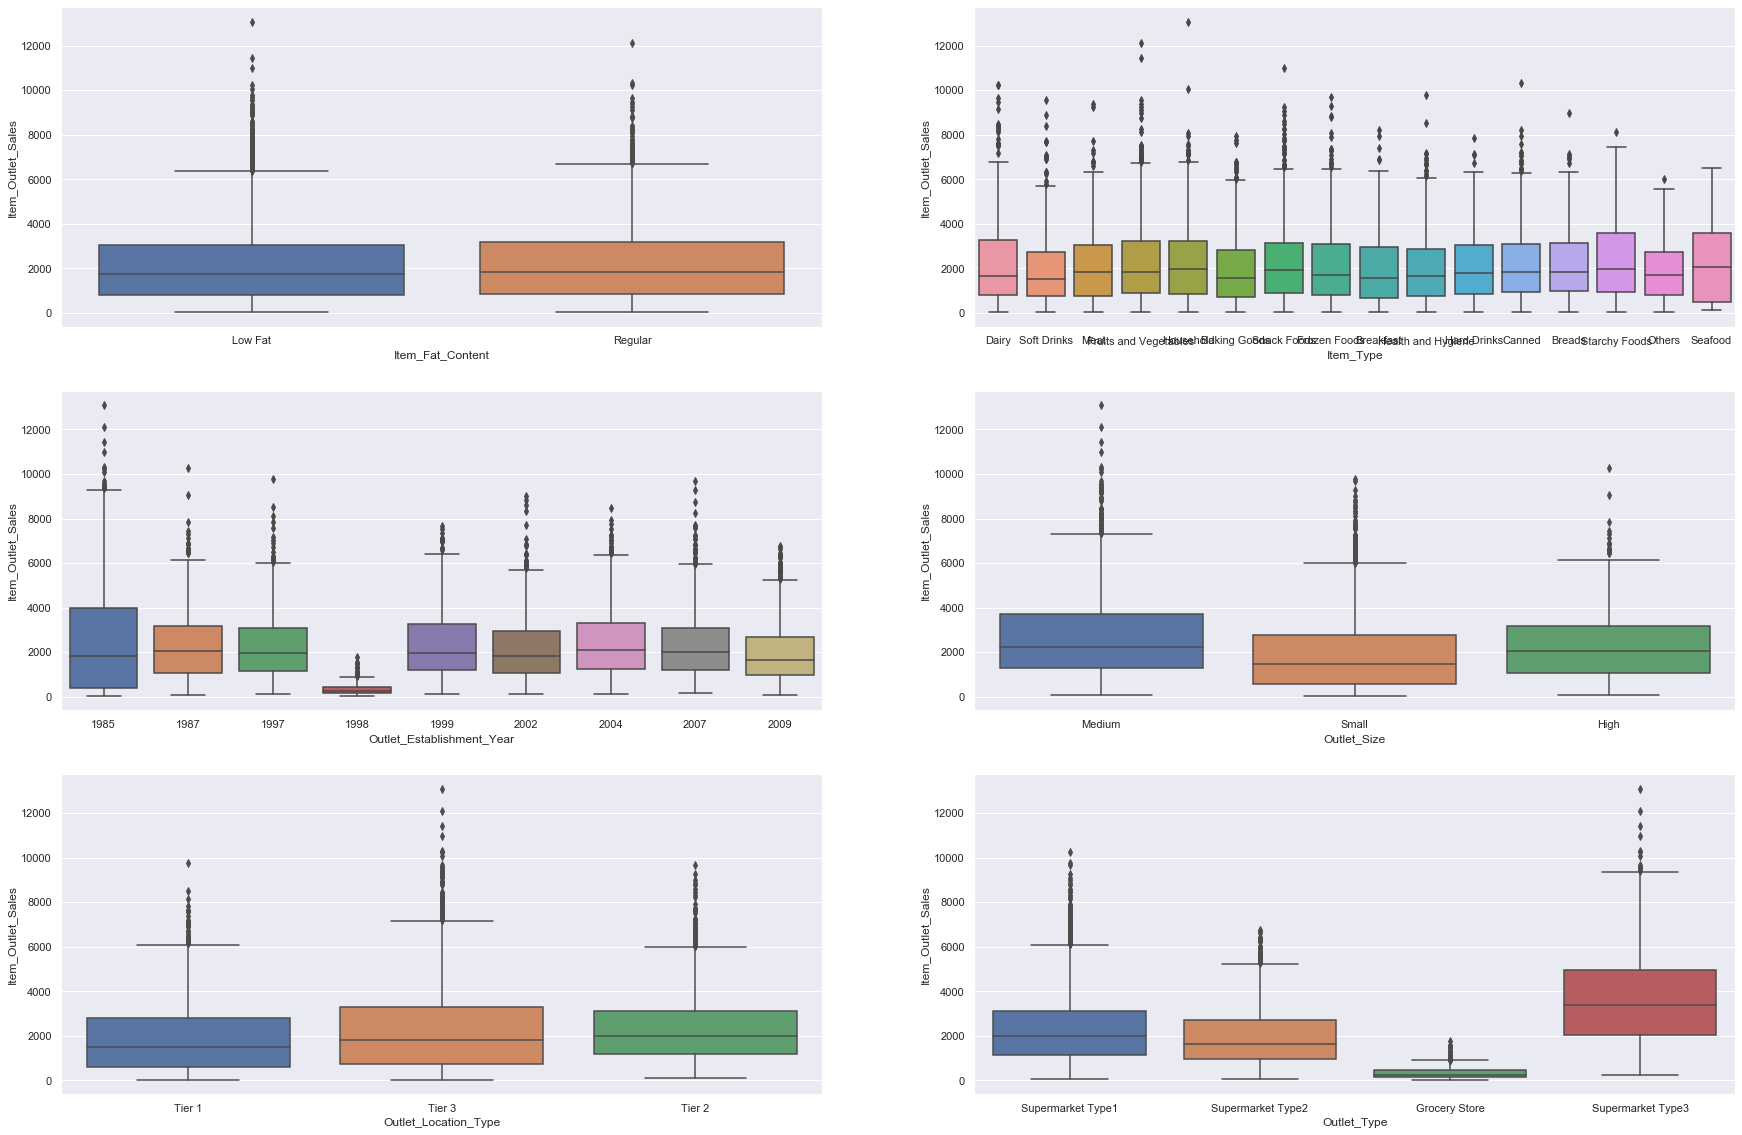

In [28]:
f, ax = plt.subplots(nrows = 3, ncols=2,figsize = (30,20))
axx = ax.flatten()
for pos,col in enumerate(col_cat):
    sns.boxplot(y = data['Item_Outlet_Sales'],x = data[col],ax = axx[pos])

## `Numerical Variables`

In [29]:
col_num = ['Item_Weight', 'Item_Visibility','Item_MRP']

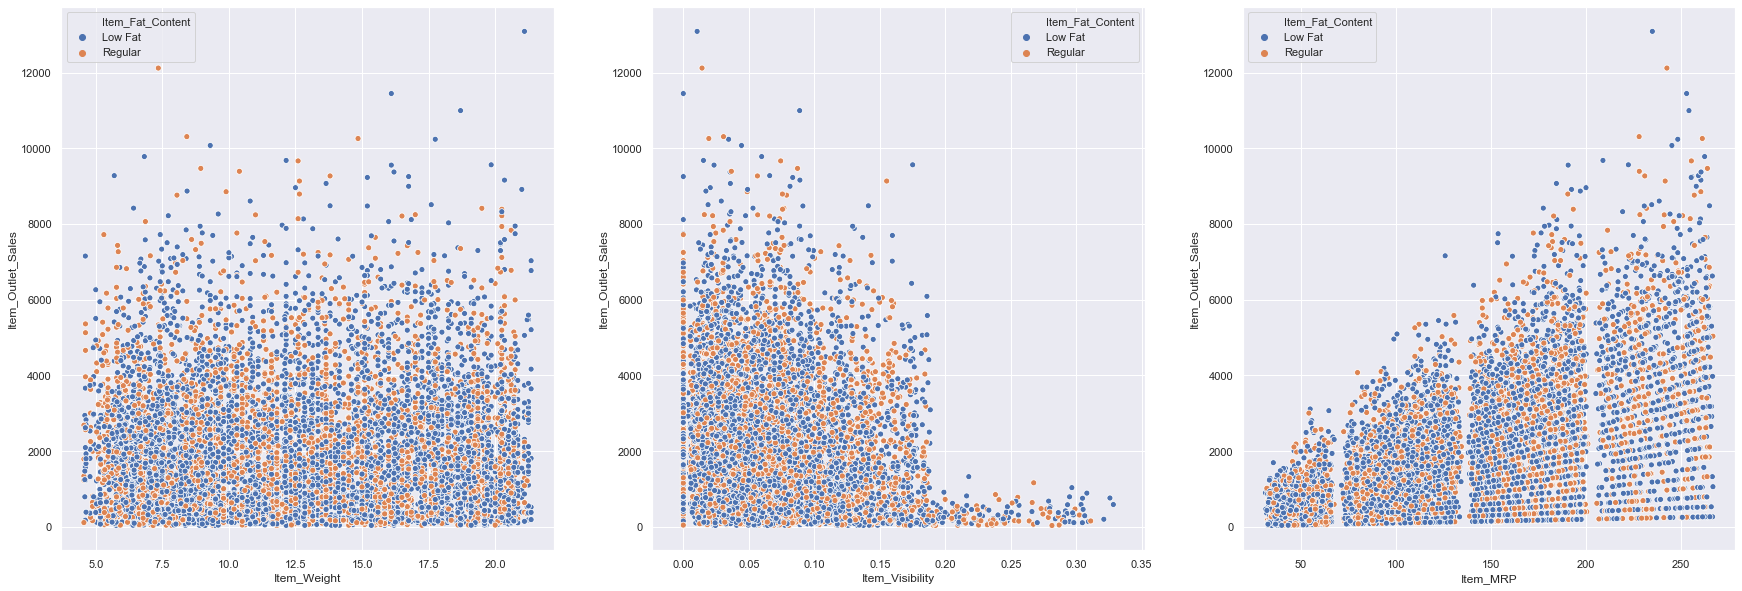

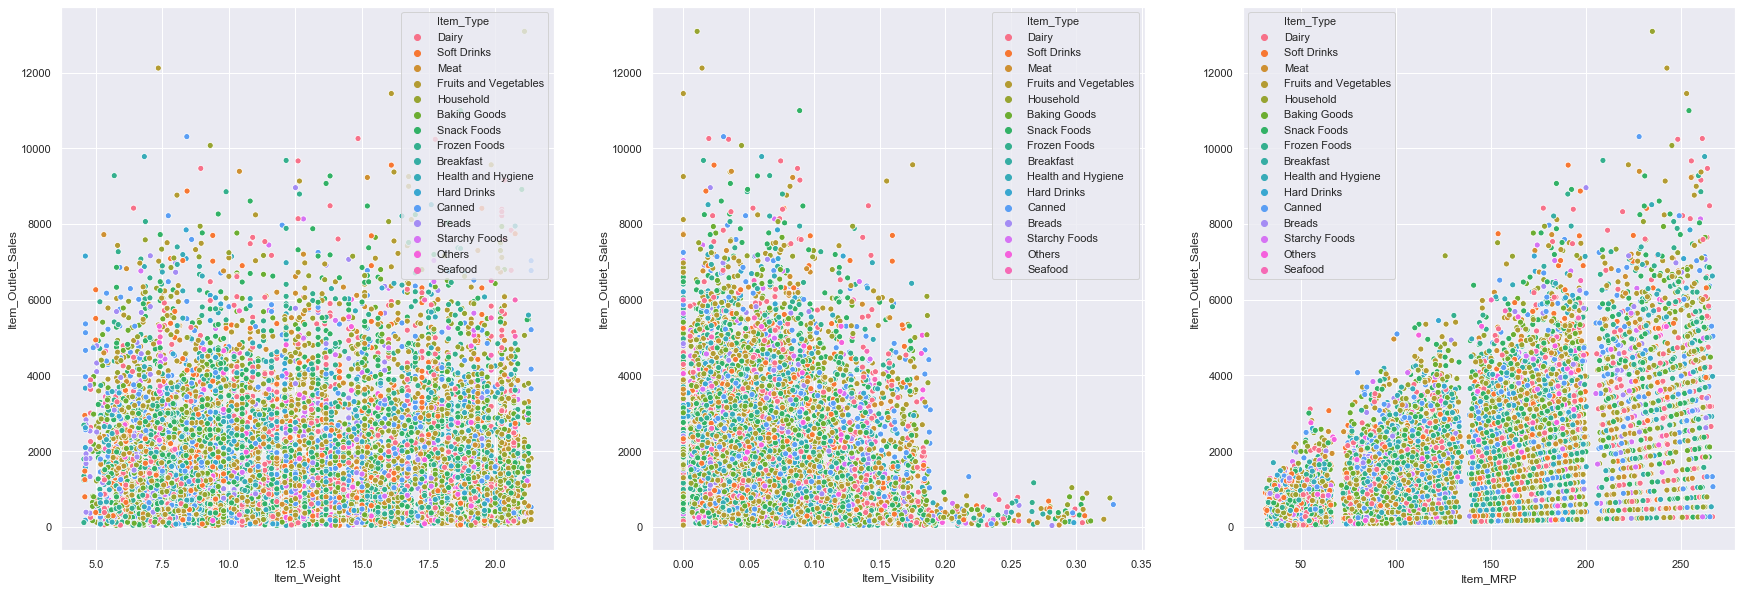

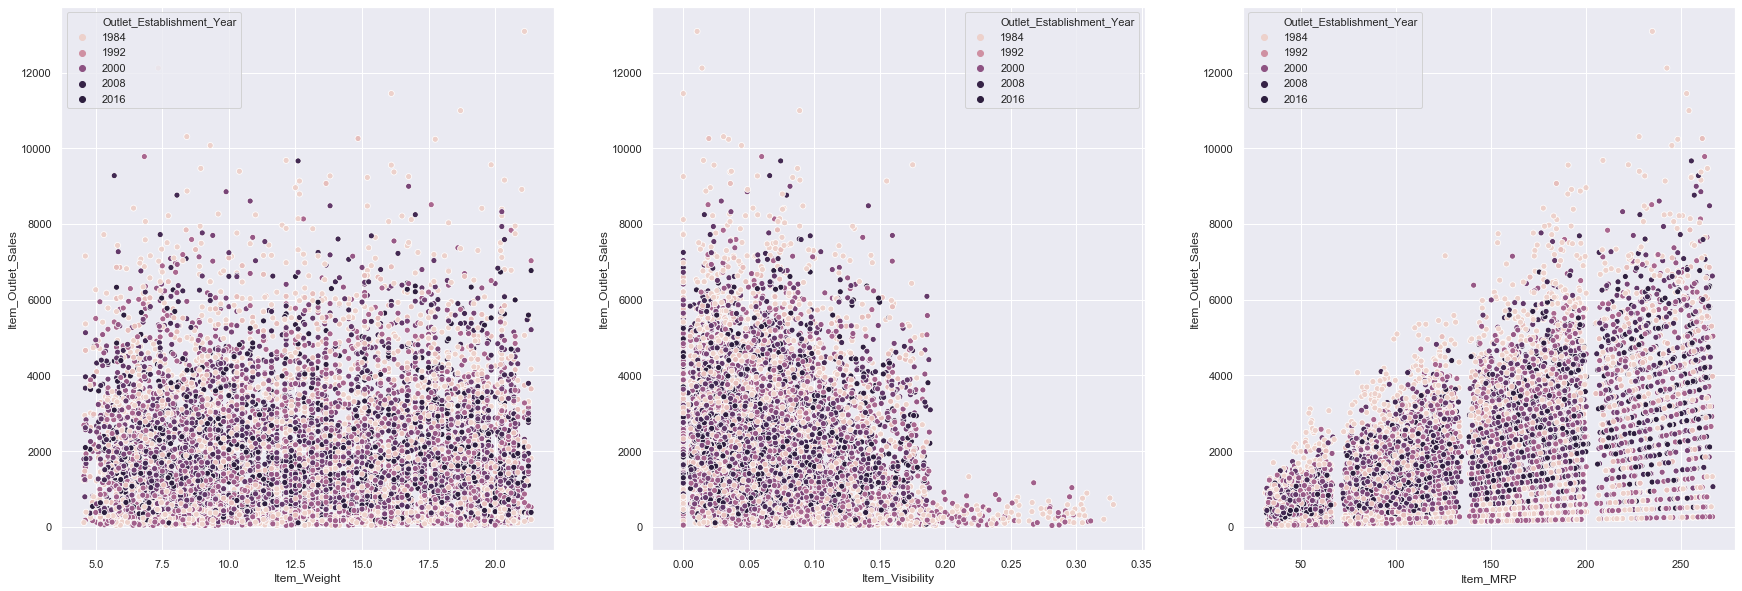

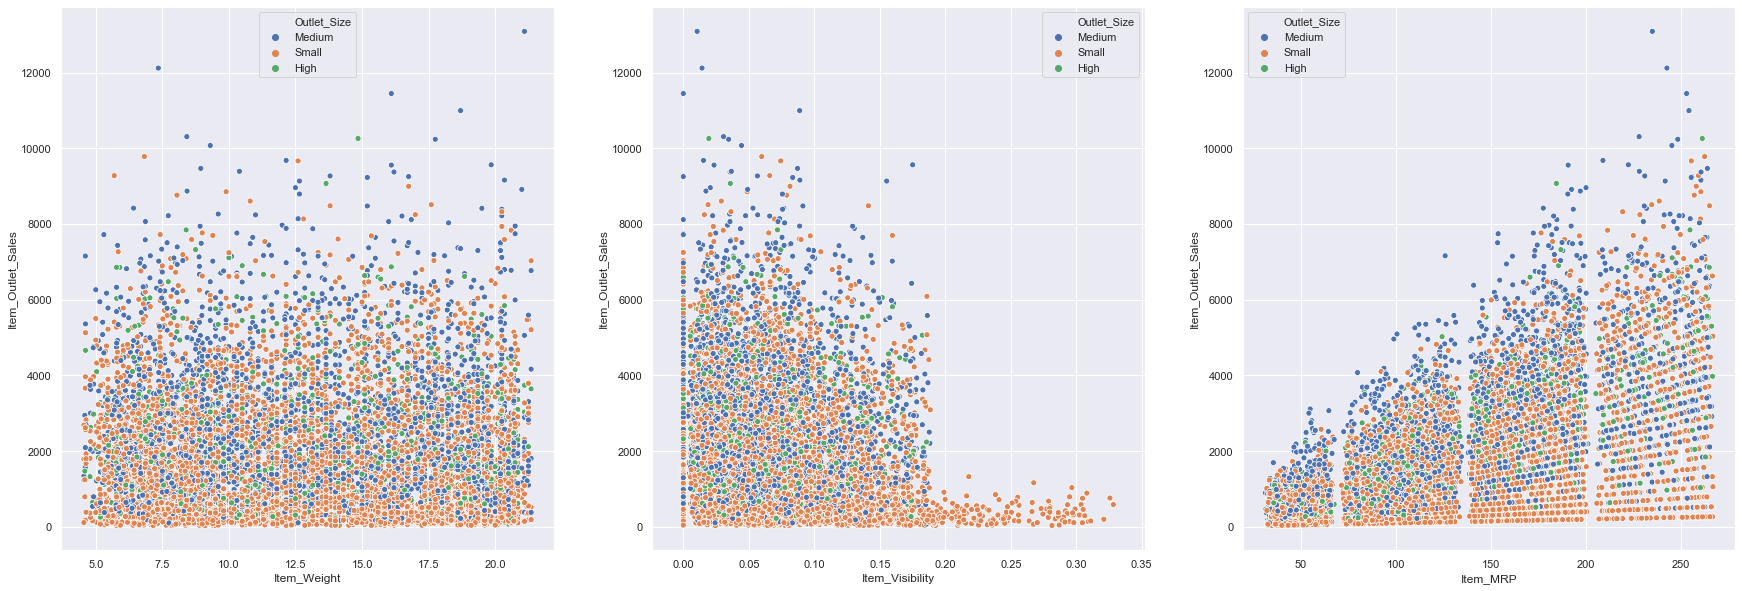

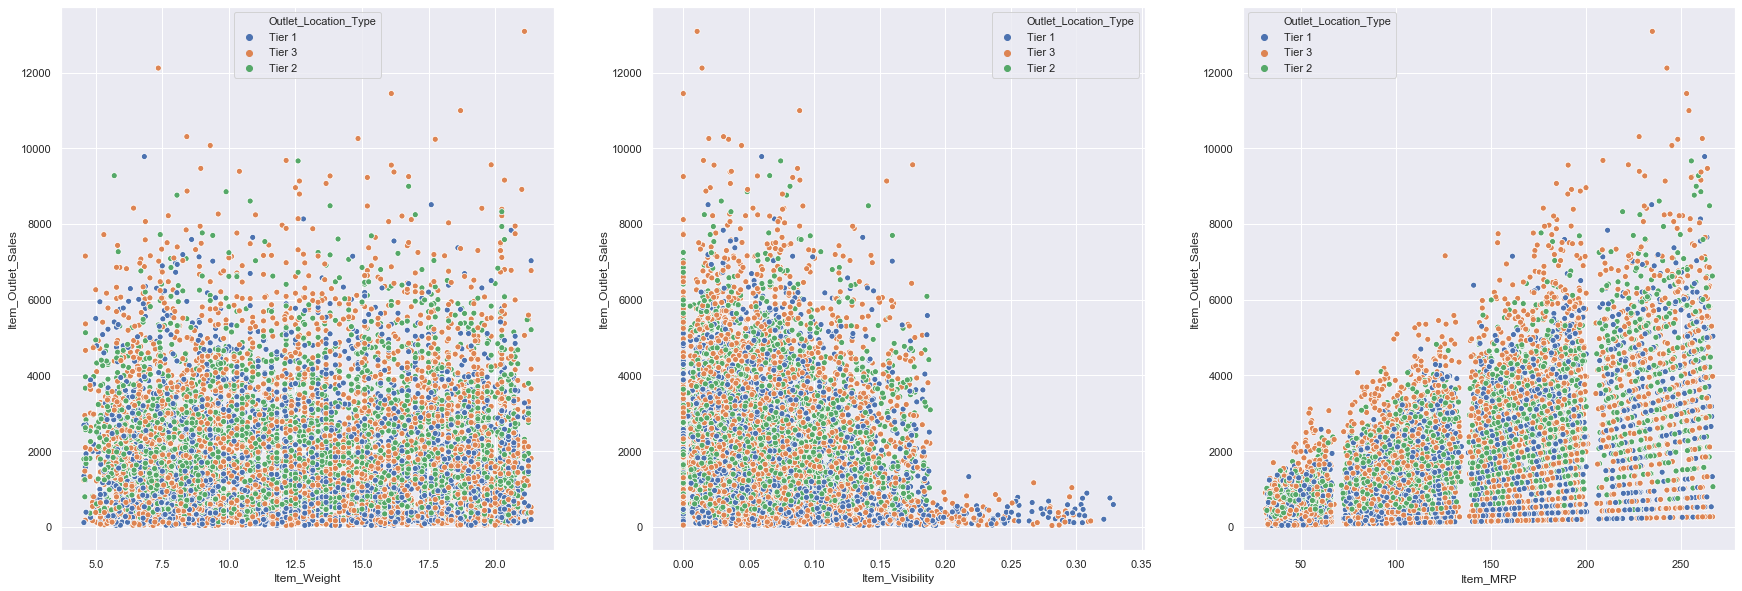

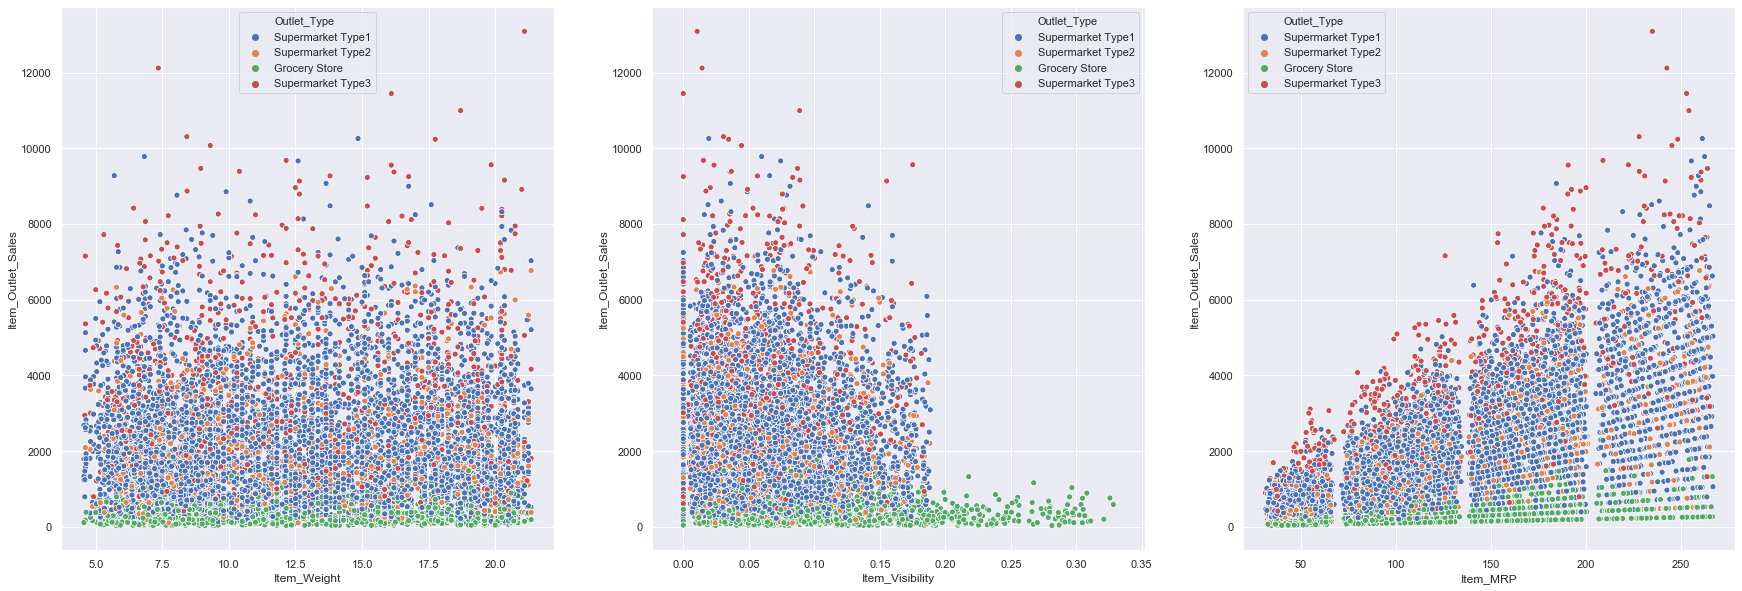

In [30]:
for cat in col_cat:
    f, ax = plt.subplots(nrows=1, ncols=3, figsize=(30,10))
    axx = ax.flatten()
    for pos,col in enumerate(col_num):
        sns.scatterplot(y = data['Item_Outlet_Sales'],x = data[col],ax = axx[pos], hue = data[cat] )

---
### Replacing "Item_Visibility" = 0 with median value of 'Item_Visibility' of same 'Item_Type' 

In [31]:
data[ data['Item_Visibility'] == 0]

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
3              FDX07       19.200          Regular              0.0   
4              NCD19        8.930          Low Fat              0.0   
5              FDP36       10.395          Regular              0.0   
10             FDY07       11.800          Low Fat              0.0   
32             FDP33       18.700          Low Fat              0.0   
...              ...          ...              ...              ...   
5643           FDQ19        7.350          Regular              0.0   
5648           FDK26        5.460          Regular              0.0   
5654           FDQ57        7.275          Low Fat              0.0   
5661           DRG37       16.200          Low Fat              0.0   
5679           FDJ26       15.300          Regular              0.0   

                  Item_Type  Item_MRP Outlet_Identifier  \
3     Fruits and Vegetables  182.0950            OUT010   
4                 Household   53.8614            OUT013   
5              Baking Goods   51.4008            OUT018   
10    Fruits and Vegetables   45.5402            OUT049   
32              Snack Foods  256.6672            OUT018   
...                     ...       ...               ...   
5643  Fruits and Vegetables  244.3512            OUT019   
5648                 Canned  187.5240            OUT027   
5654            Snack Foods  144.5760            OUT013   
5661            Soft Drinks  155.7972            OUT027   
5679                 Canned  214.6218            OUT017   

      Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
3                          1998       Small               Tier 3   
4                          1987        High               Tier 3   
5                          2009      Medium               Tier 3   
10                         1999      Medium               Tier 1   
32                         2009      Medium               Tier 3   
...                         ...         ...                  ...   
5643                       1985       Small               Tier 1   
5648                       1985      Medium               Tier 3   
5654                       1987        High               Tier 3   
5661                       1985      Medium               Tier 3   
5679                       2007       Small               Tier 2   

            Outlet_Type Item_Outlet_Sales  is_train  
3         Grocery Store            732.38         1  
4     Supermarket Type1           994.705         1  
5     Supermarket Type2           556.609         1  
10    Supermarket Type1           1516.03         1  
32    Supermarket Type2           3068.01         1  
...                 ...               ...       ...  
5643      Grocery Store              None         0  
5648  Supermarket Type3              None         0  
5654  Supermarket Type1              None         0  
5661  Supermarket Type3              None         0  
5679  Supermarket Type1              None         0  

[879 rows x 13 columns]

In [32]:
print(data[ data['Item_Type'] == 'Baking Goods']['Item_Visibility'].mean())
print(data[ data['Item_Type'] == 'Baking Goods']['Item_Visibility'].median())

0.06789758671915273
0.0600083505


In [33]:
# Creating dictionary

item_visibility = data.groupby('Item_Type')['Item_Visibility'].median().to_dict()

In [34]:
item_visibility

{'Baking Goods': 0.0600083505,
 'Breads': 0.05665598349999999,
 'Breakfast': 0.0662432875,
 'Canned': 0.05036144299999999,
 'Dairy': 0.06175574,
 'Frozen Foods': 0.0568679555,
 'Fruits and Vegetables': 0.05507343,
 'Hard Drinks': 0.0584279255,
 'Health and Hygiene': 0.0459575045,
 'Household': 0.0446384245,
 'Meat': 0.0427579805,
 'Others': 0.047033756499999996,
 'Seafood': 0.054245722,
 'Snack Foods': 0.056328717,
 'Soft Drinks': 0.051003163500000004,
 'Starchy Foods': 0.060836524}

In [35]:
data.loc[ (data['Item_Visibility'] == 0), 'Item_Visibility'] = data[ data['Item_Visibility'] == 0]['Item_Type'].apply(lambda x: item_visibility[x])

---
# Outlier Analysis

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14204 entries, 0 to 5680
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            14204 non-null  object 
 1   Item_Weight                14204 non-null  float64
 2   Item_Fat_Content           14204 non-null  object 
 3   Item_Visibility            14204 non-null  float64
 4   Item_Type                  14204 non-null  object 
 5   Item_MRP                   14204 non-null  float64
 6   Outlet_Identifier          14204 non-null  object 
 7   Outlet_Establishment_Year  14204 non-null  int64  
 8   Outlet_Size                14204 non-null  object 
 9   Outlet_Location_Type       14204 non-null  object 
 10  Outlet_Type                14204 non-null  object 
 11  Item_Outlet_Sales          8523 non-null   object 
 12  is_train                   14204 non-null  int64  
dtypes: float64(3), int64(2), object(8)
memory usage

In [37]:
col_ls = data.select_dtypes(exclude='object').columns

In [38]:
col_ls = col_ls[:-2]
col_ls

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP'], dtype='object')

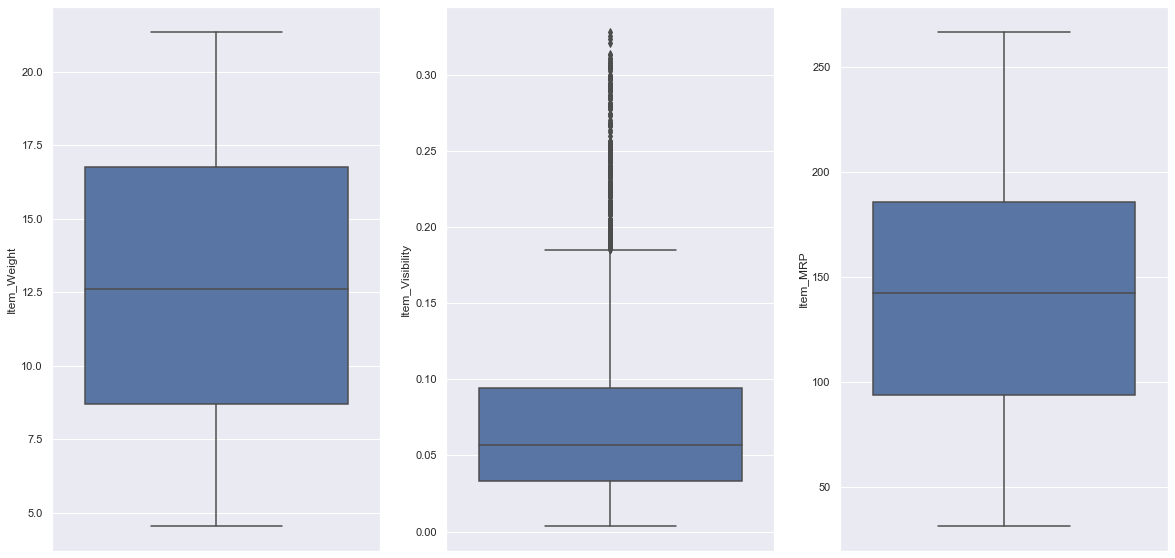

In [39]:
f,ax = plt.subplots(nrows=1,ncols=3,figsize = (20,10))
axx = ax.flatten()
for pos,col in enumerate(col_ls):
    sns.boxplot(data[col], ax = axx[pos],orient='v')

## Removing Outliers in 'Item_Visibility'

In [40]:
data.loc[ (data['Item_Visibility'] >0.185), 'Item_Visibility'] = data[ data['Item_Visibility'] > 0.185]['Item_Type'].apply(lambda x: item_visibility[x])

In [41]:
data.loc[ (data['Item_Visibility'] >0.175)]

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
126            DRI49       14.150          Low Fat         0.183507   
179            FDO24       11.100          Low Fat         0.176573   
259            FDS12        9.100          Low Fat         0.175103   
359            FDJ56        8.985          Low Fat         0.182515   
393            FDU02       13.350          Low Fat         0.179484   
...              ...          ...              ...              ...   
5205           DRI49       14.150          Low Fat         0.183355   
5462           NCE31        7.670          Low Fat         0.184809   
5473           FDD52       18.250          Regular         0.183667   
5568           FDO27        6.175          Regular         0.178928   
5601           NCO53       16.200          Low Fat         0.175039   

                  Item_Type  Item_MRP Outlet_Identifier  \
126             Soft Drinks   82.4276            OUT046   
179            Baking Goods  157.4604            OUT045   
259            Baking Goods  127.5362            OUT017   
359   Fruits and Vegetables   98.7700            OUT027   
393                   Dairy  228.9352            OUT019   
...                     ...       ...               ...   
5205            Soft Drinks   80.9276            OUT013   
5462              Household   35.2216            OUT035   
5473                  Dairy  108.6570            OUT045   
5568                   Meat   96.2752            OUT013   
5601     Health and Hygiene  182.1608            OUT013   

      Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
126                        1997       Small               Tier 1   
179                        2002       Small               Tier 2   
259                        2007       Small               Tier 2   
359                        1985      Medium               Tier 3   
393                        1985       Small               Tier 1   
...                         ...         ...                  ...   
5205                       1987        High               Tier 3   
5462                       2004       Small               Tier 2   
5473                       2002       Small               Tier 2   
5568                       1987        High               Tier 3   
5601                       1987        High               Tier 3   

            Outlet_Type Item_Outlet_Sales  is_train  
126   Supermarket Type1           1137.19         1  
179   Supermarket Type1           3010.75         1  
259   Supermarket Type1           4655.94         1  
359   Supermarket Type3           2696.49         1  
393       Grocery Store           916.141         1  
...                 ...               ...       ...  
5205  Supermarket Type1              None         0  
5462  Supermarket Type1              None         0  
5473  Supermarket Type1              None         0  
5568  Supermarket Type1              None         0  
5601  Supermarket Type1              None         0  

[138 rows x 13 columns]

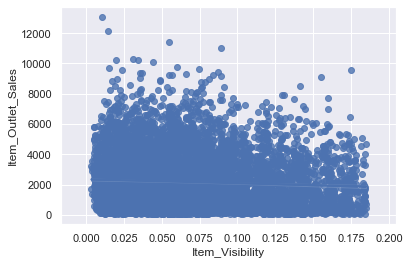

In [42]:
sns.regplot(x='Item_Visibility',y='Item_Outlet_Sales',data=data)

## Exporting Prepared Data

In [43]:
data.to_csv(r"D:\Data Science Course\Projects\Analytics vidya\Big Mart Sales Prediction\concat_data.csv", index=False)

In [44]:
data = pd.read_csv(r"D:\Data Science Course\Projects\Analytics vidya\Big Mart Sales Prediction\concat_data.csv")

In [45]:
sample_sub = pd.read_csv(r"D:\Data Science Course\Projects\Analytics vidya\Big Mart Sales Prediction\sample_submission_8RXa3c6.csv")

---
# One Hot Encoding

In [46]:
data.drop(['Outlet_Establishment_Year'],axis = 1,inplace=True)

In [47]:
cat_col = data.select_dtypes(include='object').columns

In [49]:
cat_col

Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

In [50]:
data = pd.get_dummies(data = data,columns = cat_col, drop_first=True)
data.shape

(14204, 1595)

In [51]:
data.head()

Item_Weight  Item_Visibility  Item_MRP  Item_Outlet_Sales  is_train  \
0         9.30         0.016047  249.8092          3735.1380         1   
1         5.92         0.019278   48.2692           443.4228         1   
2        17.50         0.016760  141.6180          2097.2700         1   
3        19.20         0.055073  182.0950           732.3800         1   
4         8.93         0.044638   53.8614           994.7052         1   

   Item_Identifier_DRA24  Item_Identifier_DRA59  Item_Identifier_DRB01  \
0                      0                      0                      0   
1                      0                      0                      0   
2                      0                      0                      0   
3                      0                      0                      0   
4                      0                      0                      0   

   Item_Identifier_DRB13  Item_Identifier_DRB24  ...  \
0                      0                      0  ...   
1                      0                      0  ...   
2                      0                      0  ...   
3                      0                      0  ...   
4                      0                      0  ...   

   Outlet_Identifier_OUT045  Outlet_Identifier_OUT046  \
0                         0                         0   
1                         0                         0   
2                         0                         0   
3                         0                         0   
4                         0                         0   

   Outlet_Identifier_OUT049  Outlet_Size_Medium  Outlet_Size_Small  \
0                         1                   1                  0   
1                         0                   1                  0   
2                         1                   1                  0   
3                         0                   0                  1   
4                         0                   0                  0   

   Outlet_Location_Type_Tier 2  Outlet_Location_Type_Tier 3  \
0                            0                            0   
1                            0                            1   
2                            0                            0   
3                            0                            1   
4                            0                            1   

   Outlet_Type_Supermarket Type1  Outlet_Type_Supermarket Type2  \
0                              1                              0   
1                              0                              1   
2                              1                              0   
3                              0                              0   
4                              1                              0   

   Outlet_Type_Supermarket Type3  
0                              0  
1                              0  
2                              0  
3                              0  
4                              0  

[5 rows x 1595 columns]

In [54]:
scaler = MinMaxScaler()

In [55]:
col_ls = ['Item_Weight','Item_MRP']

In [56]:
data[col_ls] = scaler.fit_transform(data[col_ls])

In [57]:
print(data.duplicated().sum())


0


# Train Test Split (Final Prediction)

In [63]:
train1 = data[ data['is_train'] == 1]
test1 = data[ data['is_train'] == 0]

In [64]:
train1.drop(['is_train'], inplace=True, axis=1)
test1.drop(['is_train'], inplace=True, axis=1)
test1.drop(['Item_Outlet_Sales'], inplace=True, axis=1)

In [65]:
train1 = train1[ [col for col in train1 if col!='Item_Outlet_Sales'] + ['Item_Outlet_Sales']]

In [66]:
X_train = train1.iloc[:,:-1]
y_train = train1.iloc[:,-1]
X_test = test1

In [67]:
X_test.reset_index(drop=True)

Item_Weight  Item_Visibility  Item_MRP  Item_Identifier_DRA24  \
0        0.964275         0.007565  0.325012                      0   
1        0.222983         0.038428  0.237819                      0   
2        0.598095         0.099575  0.893316                      0   
3        0.164335         0.015388  0.525233                      0   
4        0.538553         0.118599  0.861381                      0   
...           ...              ...       ...                    ...   
5676     0.353974         0.013496  0.467004                      0   
5677     0.181304         0.142991  0.585126                      0   
5678     0.324204         0.073529  0.371199                      0   
5679     0.639774         0.050361  0.778154                      0   
5680     0.294433         0.104720  0.205884                      0   

      Item_Identifier_DRA59  Item_Identifier_DRB01  Item_Identifier_DRB13  \
0                         0                      0                      0   
1                         0                      0                      0   
2                         0                      0                      0   
3                         0                      0                      0   
4                         0                      0                      0   
...                     ...                    ...                    ...   
5676                      0                      0                      0   
5677                      0                      0                      0   
5678                      0                      0                      0   
5679                      0                      0                      0   
5680                      0                      0                      0   

      Item_Identifier_DRB24  Item_Identifier_DRB25  Item_Identifier_DRB48  \
0                         0                      0                      0   
1                         0                      0                      0   
2                         0                      0                      0   
3                         0                      0                      0   
4                         0                      0                      0   
...                     ...                    ...                    ...   
5676                      0                      0                      0   
5677                      0                      0                      0   
5678                      0                      0                      0   
5679                      0                      0                      0   
5680                      0                      0                      0   

      ...  Outlet_Identifier_OUT045  Outlet_Identifier_OUT046  \
0     ...                         0                         0   
1     ...                         0                         0   
2     ...                         0                         0   
3     ...                         0                         0   
4     ...                         0                         0   
...   ...                       ...                       ...   
5676  ...                         0                         1   
5677  ...                         0                         0   
5678  ...                         1                         0   
5679  ...                         0                         0   
5680  ...                         1                         0   

      Outlet_Identifier_OUT049  Outlet_Size_Medium  Outlet_Size_Small  \
0                            1                   1                  0   
1                            0                   0                  1   
2                            0                   0                  1   
3                            0                   0                  1   
4                            0                   1                  0   
...                        ...                 ...                ...   
5676       

## Random Forest After Hyperparaeter Tuning  (Best Accuracy on test data)

In [68]:
model = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0,
                      n_estimators=150, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [69]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

---
## XGBoost

In [81]:
model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=150,
       n_jobs=-1, nthread=None, random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, subsample=1)

In [82]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

---
# Bagging

In [90]:
dt = DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=62,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=41, min_samples_split=93,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [91]:
model = BaggingRegressor(base_estimator=dt, n_estimators=500, random_state=0)


In [92]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

---
## Putting Predicted Values in Submission CSV 

In [94]:
submit = sample_sub.copy()

In [95]:
submit['Item_Outlet_Sales'] = y_pred

In [96]:
submit

Item_Identifier Outlet_Identifier  Item_Outlet_Sales
0              FDW58            OUT049        1639.422590
1              FDW14            OUT017        1489.874999
2              NCN55            OUT010         610.611835
3              FDQ58            OUT017        2553.864760
4              FDY38            OUT027        6199.270203
...              ...               ...                ...
5676           FDB58            OUT046        2083.128011
5677           FDD47            OUT018        2424.538078
5678           NCO17            OUT045        2016.301909
5679           FDJ26            OUT017        3759.024136
5680           FDU37            OUT045        1371.205832

[5681 rows x 3 columns]

In [97]:
min(y_pred)

152.34922309338282

---
# Eliminating Negative Values When Needed
### Replacing with Random Forest predictions

In [98]:
if min(y_pred)<0:
    ind = submit[submit['Item_Outlet_Sales']<0].index
    model = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0,
                      n_estimators=150, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test.iloc[ind])
    submit.loc[ (submit['Item_Outlet_Sales']<0), 'Item_Outlet_Sales'] = y_pred

## Exporting Submition CSV

In [100]:
submit.to_csv(r"D:\Data Science Course\Projects\Analytics vidya\Big Mart Sales Prediction\submit.csv", index=False)